In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from sklearn import metrics
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Subset
import numpy as np
import copy
import statistics
import matplotlib.pyplot as plt
import time
from tqdm import tqdm

import sys
sys.path.append('./../src')
import globals
from model import Net
from training import train_model, train_model_CL
from visualizations import plot_embeddings, plot_confusion_matrix
from feature_attribution import Feature_Importance_Evaluations
from pytorch_utils import get_features, get_labels
from embedding_measurements import measure_embedding_confusion_knn, measure_embedding_drift

In [2]:
ITERATIONS = globals.ITERATIONS
CLASSES_PER_ITER = globals.CLASSES_PER_ITER
SEED = globals.SEED
DEVICE = globals.DEVICE
full_trainset = globals.full_trainset
trainset = globals.trainset
testset = globals.testset
trainloaders = globals.trainloaders
valloaders = globals.valloaders
testloaders = globals.testloaders

In [3]:
# This is the two-step process used to prepare the
# data for use with the convolutional neural network.

# First step is to convert Python Image Library (PIL) format
# to PyTorch tensors.

# Second step is used to normalize the data by specifying a 
# mean and standard deviation for each of the three channels.
# This will convert the data from [0,1] to [-1,1]

# Normalization of data should help speed up conversion and
# reduce the chance of vanishing gradients with certain 
# activation functions.
def initialize_data():
    transform = transforms.Compose([
        transforms.ToTensor()
        #transforms.Normalize((0.5,), (0.5,))  # Normalizes to mean 0.5 and std 0.5 for the single channel
    ])

    globals.full_trainset = torchvision.datasets.MNIST('./../data/', train=True, download=True,
                                transform=transform)
    targets = np.array(globals.full_trainset.targets)

    # Perform stratified split
    train_indices, val_indices = train_test_split(
        np.arange(len(targets)),
        test_size=0.15,
        stratify=targets
    )

    # Create subsets
    valset = Subset(globals.full_trainset, val_indices)
    globals.trainset = Subset(globals.full_trainset, train_indices)

    globals.testset = torchvision.datasets.MNIST('./../data/', train=False, download=True,
                                transform=transform)

    # Define class pairs for each subset
    class_pairs = [tuple(range(i*CLASSES_PER_ITER,(i+1)*CLASSES_PER_ITER)) for i in range(ITERATIONS)]
    #print(class_pairs)

    # Dictionary to hold data loaders for each subset
    globals.trainloaders = []
    globals.testloaders = []
    globals.valloaders = []
    subset_indices = []
    # Loop over each class pair
    for i, t in enumerate(class_pairs):
        # Get indices of images belonging to the specified class pair
        subs_ind = [idx for idx, (_, label) in enumerate(globals.trainset) if label in list(t)]
        val_subset_indices = [idx for idx, (_, label) in enumerate(valset) if label in list(t)]
        test_subset_indices = [idx for idx, (_, label) in enumerate(globals.testset) if label in list(t)]
        # Create a subset for the current class pair
        train_subset = Subset(globals.trainset, subs_ind)
        globals.trainloaders.append(DataLoader(train_subset, batch_size=globals.BATCH_SIZE, shuffle=True, pin_memory=True, num_workers = 0))

        subset_indices.append(subs_ind)
        
        val_subset = Subset(valset, val_subset_indices)
        globals.valloaders.append(DataLoader(val_subset, batch_size=500, shuffle=False))

        test_subset = Subset(globals.testset, test_subset_indices)
        globals.testloaders.append(DataLoader(test_subset, batch_size=500, shuffle=False))


In [4]:
def run_experiment(
        verbose = False,
        stopOnLoss = 0.03,
        full_CE = True,
        with_OOD = False,
        kd_loss = 0,
        stopOnValAcc = None,
        epochs = 1000000
        ):
    def _print(*args, **kwargs):
        if verbose:
            print(*args, **kwargs)
    if with_OOD:
        globals.OOD_CLASS = 1
    else:
        globals.OOD_CLASS = 0
    initialize_data()
    prevModel = None
    globals.OOD_CLASS=1
    globals.BATCH_SIZE=4

    #[Denis] added code:
    Feature_Importance_Eval=Feature_Importance_Evaluations(globals.valloaders, DEVICE)

    for i in tqdm(range(ITERATIONS), desc="Experiment Progress"):
        model = Net((i+1)*(CLASSES_PER_ITER+globals.OOD_CLASS), withDropout=True)
        if prevModel is not None:
            with torch.no_grad():
                model.copyPrev(prevModel)
        train_loader = globals.trainloaders[i]
        val_loader = globals.valloaders[i]
        if prevModel:
            _print("CL TRAIN!!")
            train_model_CL(
                model,
                prevModel,
                train_loader,
                val_loader,
                i,
                verbose,
                epochs,
                True,
                freeze_nonzero_params=False,
                l1_loss=0,
                ewc_loss=0,
                kd_loss=kd_loss,
                distance_loss=0,
                center_loss=0,
                param_reuse_loss=0,
                stopOnLoss=stopOnLoss,
                stopOnValAcc = stopOnValAcc,
                full_CE=full_CE
                )
        else:
            train_model(
                model, 
                train_loader, 
                val_loader, 
                verbose, 
                epochs=epochs, 
                l1_loss=0,
                stopOnLoss=stopOnLoss,
                center_loss =0,
                )

        #[Denis] added code:
        Feature_Importance_Eval.Task_Feature_Attribution(model, i)
        
        if verbose or i == ITERATIONS-1:
            print("Starting evaluation")
            _print("ITERATION", i+1)
            _print("ACCURACIES PER TASK:")
            accumPred = []
            all_labels = []
            all_embeddings = []
            with torch.no_grad():
                for j in range(i+1):
                    val_loader = globals.testloaders[j]
                    val_labels = get_labels(val_loader).to(DEVICE)
                    all_labels.append(val_labels)
                    model.eval()
                    pred, embeddings = model.get_pred_and_embeddings((get_features(val_loader).to(DEVICE)))
                    model.train()
                    accumPred.append(pred)
                    all_embeddings.append(embeddings)
                    sliced_pred = pred[:, j*(CLASSES_PER_ITER+globals.OOD_CLASS):(j+1)*(CLASSES_PER_ITER+globals.OOD_CLASS)]
                    _, predicted = torch.max(sliced_pred, 1)  # Get the class predictions
                    predicted += j*CLASSES_PER_ITER
                    correct = (predicted == val_labels).sum().item()  # Count how many were correct
                    accuracy = correct / val_labels.size(0)  # Accuracy as a percentage
                    _print(str(accuracy), end=' ')
            accumPred = torch.cat(accumPred)
            all_labels = torch.cat(all_labels)
            all_embeddings = torch.cat(all_embeddings)
            predicted = []
            for x in accumPred:
                if globals.OOD_CLASS == 1:
                    x_pred = x[[i for i in range(x.size(0)) if (i + 1) % (CLASSES_PER_ITER+1) != 0]]
                else:
                    x_pred = x
                x_pred = torch.softmax(x_pred, dim=-1)
                max = 0
                for (k, v) in enumerate(x_pred):
                    if v > max:
                        max = v
                        p = k
                predicted.append(p)
            predicted = torch.tensor(predicted).to(DEVICE)
            correct = (predicted == all_labels).sum().item()  # Count how many were correct
            accuracy = correct / all_labels.size(0)  # Accuracy as a percentage
            _print("Accuracy on tasks so far:", accuracy)

            embedding_drift = measure_embedding_drift(all_embeddings, all_labels, model.prev_test_embedding_centers)
            _print("Average embedding drift based on centroids:", embedding_drift)
            total_confusion, intra_phase_confusion, per_task_confusion = measure_embedding_confusion_knn(all_embeddings, all_labels, k = 500, task=i+1)
            _print("Total confusion", total_confusion)
            _print("Intra-phase confusion", intra_phase_confusion)
            _print("Per task confusions", per_task_confusion)
            if verbose:
                plot_confusion_matrix(predicted.cpu(), all_labels.cpu(), list(range(CLASSES_PER_ITER*(i+1))))
        prevModel = copy.deepcopy(model)
        
    #[Denis] added code:
    avg_shap_val,shap_vals=Feature_Importance_Eval.Get_Feature_Change_Score(prevModel)
    _print("Average SHAPC values (ordered as tasks):", shap_vals)
    _print("Averaged SHAPC value:", avg_shap_val)
    
    return accuracy, total_confusion, intra_phase_confusion, per_task_confusion, embedding_drift, avg_shap_val

In [5]:
def run_experiments(n_runs=1, *args, **kwargs):
    verbose = kwargs.get('verbose', None)
    def _print(*args, **kwargs):
        if verbose:
            print(*args, **kwargs)
    accuracies = []
    total_confusions = []
    intra_phase_confusions = []
    per_task_confusions = []
    shap_vals = []
    embedding_drifts = []
    for r in range(n_runs):
        print(f"Starting run {r+1}.")
        accuracy, total_confusion, intra_phase_confusion, per_task_confusion, embedding_drift, avg_shap_val = run_experiment(*args, **kwargs)
        accuracies.append(accuracy)
        total_confusions.append(total_confusion)
        intra_phase_confusions.append(intra_phase_confusion)
        per_task_confusions.append(per_task_confusion)
        shap_vals.append(avg_shap_val)
        _print(f"Run {r} finished with accuracy {accuracy}")
    
    # Calculate means and standard deviations for each measure
    mean_acc = statistics.mean(accuracies)
    acc_std = statistics.stdev(accuracies)

    mean_total_confusion = statistics.mean(total_confusions)
    total_confusion_std = statistics.stdev(total_confusions)

    mean_intra_phase_confusion = statistics.mean(intra_phase_confusions)
    intra_phase_confusion_std = statistics.stdev(intra_phase_confusions)

    mean_per_task_confusion = statistics.mean(per_task_confusions)
    per_task_confusion_std = statistics.stdev(per_task_confusions)

    mean_embedding_drift = statistics.mean(embedding_drifts)
    embedding_drift_std = statistics.stdev(embedding_drift)

    mean_shap_val = statistics.mean(shap_vals)
    shap_val_std = statistics.stdev(shap_vals)

    # Print all results
    print("Accuracies:")
    print(accuracies)
    print(f"Mean accuracy across {n_runs} runs: {mean_acc}")
    print(f"Standard deviation of accuracy across {n_runs} runs: {acc_std}\n")

    print("Total Confusions:")
    print(total_confusions)
    print(f"Mean total confusion across {n_runs} runs: {mean_total_confusion}")
    print(f"Standard deviation of total confusion across {n_runs} runs: {total_confusion_std}\n")

    print("Intra-Phase Confusions:")
    print(intra_phase_confusions)
    print(f"Mean intra-phase confusion across {n_runs} runs: {mean_intra_phase_confusion}")
    print(f"Standard deviation of intra-phase confusion across {n_runs} runs: {intra_phase_confusion_std}\n")

    print("Per-Task Confusions:")
    print(per_task_confusions)
    print(f"Mean per-task confusion across {n_runs} runs: {mean_per_task_confusion}")
    print(f"Standard deviation of per-task confusion across {n_runs} runs: {per_task_confusion_std}\n")

    print("Embedding drifts:")
    print(per_task_confusions)
    print(f"Mean embedding drift across {n_runs} runs: {mean_per_task_confusion}")
    print(f"Standard deviation of embedding drift across {n_runs} runs: {per_task_confusion_std}\n")

    print("SHAP Values:")
    print(shap_vals)
    print(f"Mean SHAP values across {n_runs} runs: {mean_shap_val}")
    print(f"Standard deviation of SHAP values across {n_runs} runs: {shap_val_std}\n")

In [ ]:
run_experiments(n_runs=5, verbose=False, stopOnLoss = 0.02)

In [ ]:
run_experiments(n_runs=5, verbose=False, stopOnLoss = 0.02, kd_loss=1)

In [ ]:
run_experiments(n_runs=5, verbose=False, full_CE = False)

Experiment Progress:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 0, CE Loss: 0.1659, center loss: 0.0000
Validation loss 0.030142616480588913
Fraction of nonzero parameters 0.9999375365299757 

STORING CENTER FOR  0
CENTER tensor([1.4038e+00, 3.5184e-03, 2.3052e+00, 8.4105e-01, 1.0278e+00, 1.6035e+00,
        1.3591e+00, 0.0000e+00, 7.8395e-01, 2.3555e+00, 1.3683e+00, 3.1268e-01,
        3.0078e-01, 3.0337e-01, 0.0000e+00, 0.0000e+00, 1.5112e-01, 4.6232e-02,
        1.6451e-01, 1.4940e+00, 8.2582e-02, 2.2878e-02, 6.1108e-01, 1.0899e-02,
        2.7455e+00, 9.2135e-06, 1.5629e+00, 1.1001e+00, 1.8662e-03, 4.2771e-03,
        0.0000e+00, 1.2136e-01, 1.6681e-01, 2.3147e-01, 8.8351e-01, 0.0000e+00,
        1.9131e-01, 4.6804e-03, 8.1795e-03, 1.1548e+00, 4.1777e-04, 1.7701e+00,
        1.8664e-02, 3.8624e-02, 1.8616e-03, 7.3600e-03, 0.0000e+00, 2.0101e-01,
        8.1925e-04, 3.9743e-02, 0.0000e+00, 4.0186e-01, 3.9188e-03, 1.5057e+00,
        1.1163e-01, 9.0311e-01, 1.1732e+00, 1.3459e-02, 4.1917e-04, 1.4342e+00,
        2.1341e-01, 8.9027e-01, 1.78

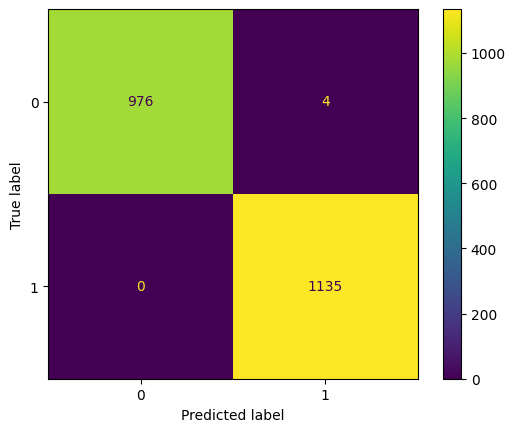

Experiment Progress:  20%|██        | 1/5 [00:17<01:10, 17.63s/it]

CL TRAIN!!
Epoch 0  CELoss: 0.1786, KLLoss: 0.0123, L1Loss: 0.0000, EWCLoss: 0.0000, CenterLoss: 0.0000, InterCenterLoss: 0.0000, ParamReuseLoss: 0.0000
Validation losses: 0.06513556186109781 0.010966279543936253
Validation accuracy (for last task) 0.906284454244763
Fraction of nonzero parameters 0.9999821840565122
Total validation accuracy 0.939940748720711


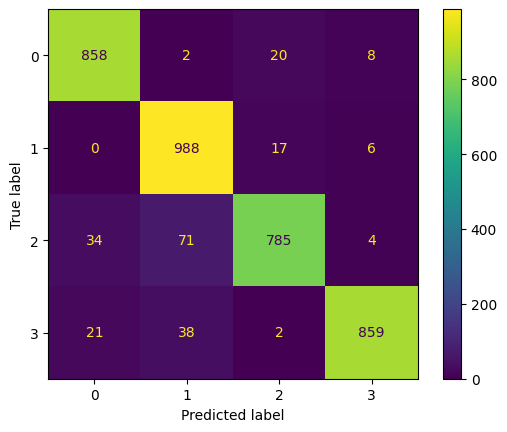

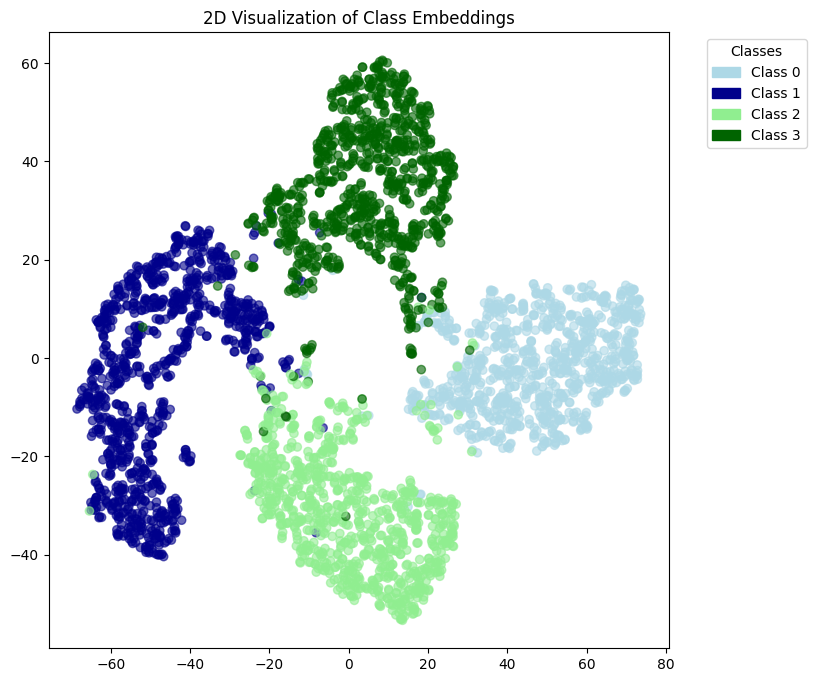



STORING CENTER FOR  2
CENTER tensor([5.0277e-02, 2.9720e-03, 1.5842e-02, 3.8324e-01, 1.1547e-03, 2.7391e-02,
        6.7804e-01, 1.8669e-01, 1.1569e+00, 3.0883e-02, 1.6427e+00, 8.1412e-01,
        2.2908e-01, 3.4457e-02, 0.0000e+00, 0.0000e+00, 6.9699e-02, 5.3002e-04,
        1.4012e+00, 7.5301e-02, 8.0740e-01, 4.4956e-01, 2.1950e-03, 2.7570e-01,
        6.8599e-01, 5.4520e-06, 1.6799e+00, 3.0767e-01, 4.6865e-03, 3.1997e-02,
        0.0000e+00, 1.3914e+00, 2.0533e-01, 3.0432e-01, 6.3179e-03, 0.0000e+00,
        7.7165e-02, 3.1148e-01, 5.9615e-01, 1.0290e+00, 4.3020e-02, 1.5685e+00,
        5.7286e-01, 3.3382e-01, 8.0883e-03, 8.1766e-03, 0.0000e+00, 1.3060e+00,
        0.0000e+00, 3.0889e-02, 0.0000e+00, 1.6778e-02, 9.6013e-04, 1.2540e+00,
        7.2752e-01, 1.1532e+00, 1.4088e+00, 1.1195e-02, 2.9900e-01, 4.5945e-01,
        1.8091e-01, 9.8910e-01, 1.6584e-01, 5.8143e-01, 4.4754e-02, 1.5269e+00,
        6.4648e-01, 5.0895e-02, 1.0391e+00, 4.3764e-01, 4.2890e-01, 6.2502e-02,
        7

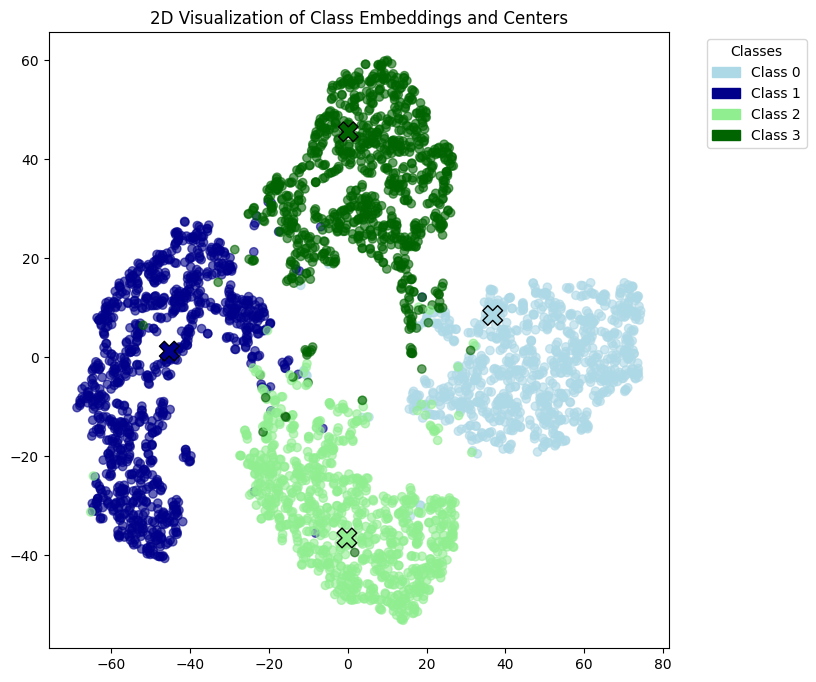

Starting evaluation
ITERATION 2
ACCURACIES PER TASK:
0.9947990543735225 0.9867776689520078 Accuracy on tasks so far: 0.954293961991821
Average embedding drift based on centroids: 2.6044106
Total confusion 0.09127592013471253
Intra-phase confusion 0.08269906182343034
Per task confusions 0.01668828270619588


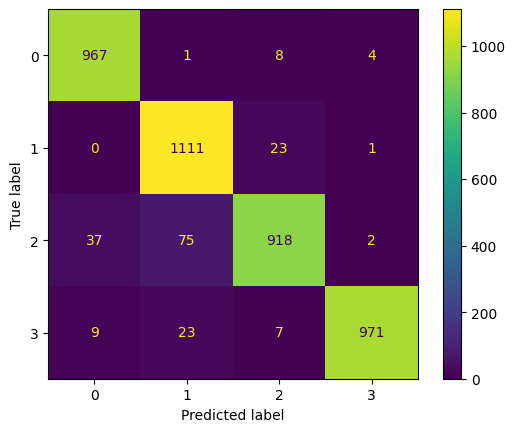

Experiment Progress:  40%|████      | 2/5 [00:57<01:32, 30.94s/it]

CL TRAIN!!


In [ ]:
#run_experiment(verbose=True, epochs=1, full_CE=False, kd_loss=1, with_OOD=True)